In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(10)   
tf.random.set_seed(10)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[26420:92469] 
Y_train_SS = Y_train_SS[26420:92469]
Y_train_V = Y_train_V[26420:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 66049
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 66049 samples, validate on 13210 samples
Epoch 1/100
65568/66049 [============================>.] - ETA: 0s - loss: 0.0296 - dense_5_loss: 0.0195 - dense_6_loss: 0.0102 - dense_5_mse: 0.0195 - dense_6_mse: 0.0102

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.01868, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


66049/66049 [==============================] - 9s 135us/sample - loss: 0.0295 - dense_5_loss: 0.0193 - dense_6_loss: 0.0102 - dense_5_mse: 0.0193 - dense_6_mse: 0.0102 - val_loss: 0.0187 - val_dense_5_loss: 0.0042 - val_dense_6_loss: 0.0145 - val_dense_5_mse: 0.0042 - val_dense_6_mse: 0.0145
Epoch 2/100
65760/66049 [============================>.] - ETA: 0s - loss: 0.0102 - dense_5_loss: 0.0032 - dense_6_loss: 0.0070 - dense_5_mse: 0.0032 - dense_6_mse: 0.0070
Epoch 2: val_loss improved from 0.01868 to 0.01094, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


66049/66049 [==============================] - 7s 109us/sample - loss: 0.0102 - dense_5_loss: 0.0032 - dense_6_loss: 0.0070 - dense_5_mse: 0.0032 - dense_6_mse: 0.0070 - val_loss: 0.0109 - val_dense_5_loss: 0.0051 - val_dense_6_loss: 0.0058 - val_dense_5_mse: 0.0051 - val_dense_6_mse: 0.0058
Epoch 3/100
65760/66049 [============================>.] - ETA: 0s - loss: 0.0105 - dense_5_loss: 0.0033 - dense_6_loss: 0.0072 - dense_5_mse: 0.0033 - dense_6_mse: 0.0072
Epoch 3: val_loss improved from 0.01094 to 0.00887, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


66049/66049 [==============================] - 7s 111us/sample - loss: 0.0104 - dense_5_loss: 0.0033 - dense_6_loss: 0.0072 - dense_5_mse: 0.0033 - dense_6_mse: 0.0072 - val_loss: 0.0089 - val_dense_5_loss: 0.0026 - val_dense_6_loss: 0.0063 - val_dense_5_mse: 0.0026 - val_dense_6_mse: 0.0063
Epoch 4/100
65824/66049 [============================>.] - ETA: 0s - loss: 0.0077 - dense_5_loss: 0.0029 - dense_6_loss: 0.0047 - dense_5_mse: 0.0029 - dense_6_mse: 0.0047
Epoch 4: val_loss improved from 0.00887 to 0.00747, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


66049/66049 [==============================] - 7s 109us/sample - loss: 0.0077 - dense_5_loss: 0.0029 - dense_6_loss: 0.0047 - dense_5_mse: 0.0029 - dense_6_mse: 0.0047 - val_loss: 0.0075 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0057 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0057
Epoch 5/100
66049/66049 [==============================] - ETA: 0s - loss: 0.0059 - dense_5_loss: 0.0023 - dense_6_loss: 0.0036 - dense_5_mse: 0.0023 - dense_6_mse: 0.0036
Epoch 5: val_loss did not improve from 0.00747
66049/66049 [==============================] - 8s 115us/sample - loss: 0.0059 - dense_5_loss: 0.0023 - dense_6_loss: 0.0036 - dense_5_mse: 0.0023 - dense_6_mse: 0.0036 - val_loss: 0.0084 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0062 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0062
Epoch 6/100
65568/66049 [============================>.] - ETA: 0s - loss: 0.0061 - dense_5_loss: 0.0024 - dense_6_loss: 0.0037 - dense_5_mse: 0.0024 - dense_6_mse: 0.0037
Epoch 6: val_loss impro

66049/66049 [==============================] - 7s 109us/sample - loss: 0.0061 - dense_5_loss: 0.0024 - dense_6_loss: 0.0037 - dense_5_mse: 0.0024 - dense_6_mse: 0.0037 - val_loss: 0.0053 - val_dense_5_loss: 0.0024 - val_dense_6_loss: 0.0029 - val_dense_5_mse: 0.0024 - val_dense_6_mse: 0.0029
Epoch 7/100
65696/66049 [============================>.] - ETA: 0s - loss: 0.0060 - dense_5_loss: 0.0024 - dense_6_loss: 0.0036 - dense_5_mse: 0.0024 - dense_6_mse: 0.0036
Epoch 7: val_loss did not improve from 0.00532
66049/66049 [==============================] - 6s 87us/sample - loss: 0.0060 - dense_5_loss: 0.0024 - dense_6_loss: 0.0036 - dense_5_mse: 0.0024 - dense_6_mse: 0.0036 - val_loss: 0.0057 - val_dense_5_loss: 0.0026 - val_dense_6_loss: 0.0031 - val_dense_5_mse: 0.0026 - val_dense_6_mse: 0.0031
Epoch 8/100
65792/66049 [============================>.] - ETA: 0s - loss: 0.0050 - dense_5_loss: 0.0020 - dense_6_loss: 0.0030 - dense_5_mse: 0.0020 - dense_6_mse: 0.0030
Epoch 8: val_loss improv

66049/66049 [==============================] - 8s 124us/sample - loss: 0.0050 - dense_5_loss: 0.0020 - dense_6_loss: 0.0030 - dense_5_mse: 0.0020 - dense_6_mse: 0.0030 - val_loss: 0.0046 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0026
Epoch 9/100
65888/66049 [============================>.] - ETA: 0s - loss: 0.0058 - dense_5_loss: 0.0022 - dense_6_loss: 0.0036 - dense_5_mse: 0.0022 - dense_6_mse: 0.0036
Epoch 9: val_loss did not improve from 0.00457
66049/66049 [==============================] - 6s 89us/sample - loss: 0.0058 - dense_5_loss: 0.0022 - dense_6_loss: 0.0037 - dense_5_mse: 0.0022 - dense_6_mse: 0.0036 - val_loss: 0.0050 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0033 - val_dense_5_mse: 0.0017 - val_dense_6_mse: 0.0033
Epoch 10/100
65984/66049 [============================>.] - ETA: 0s - loss: 0.0055 - dense_5_loss: 0.0022 - dense_6_loss: 0.0033 - dense_5_mse: 0.0022 - dense_6_mse: 0.0033
Epoch 10: val_loss impr

66049/66049 [==============================] - 8s 121us/sample - loss: 0.0055 - dense_5_loss: 0.0022 - dense_6_loss: 0.0033 - dense_5_mse: 0.0022 - dense_6_mse: 0.0033 - val_loss: 0.0027 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0016
Epoch 11/100
65504/66049 [============================>.] - ETA: 0s - loss: 0.0043 - dense_5_loss: 0.0018 - dense_6_loss: 0.0025 - dense_5_mse: 0.0018 - dense_6_mse: 0.0025
Epoch 11: val_loss did not improve from 0.00274
66049/66049 [==============================] - 6s 89us/sample - loss: 0.0043 - dense_5_loss: 0.0018 - dense_6_loss: 0.0025 - dense_5_mse: 0.0018 - dense_6_mse: 0.0025 - val_loss: 0.0033 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0018
Epoch 12/100
65664/66049 [============================>.] - ETA: 0s - loss: 0.0043 - dense_5_loss: 0.0018 - dense_6_loss: 0.0024 - dense_5_mse: 0.0018 - dense_6_mse: 0.0024
Epoch 12: val_loss di

66049/66049 [==============================] - 8s 116us/sample - loss: 0.0042 - dense_5_loss: 0.0017 - dense_6_loss: 0.0025 - dense_5_mse: 0.0017 - dense_6_mse: 0.0025 - val_loss: 0.0025 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0012
Epoch 20/100
65568/66049 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018
Epoch 20: val_loss did not improve from 0.00246
66049/66049 [==============================] - 7s 101us/sample - loss: 0.0031 - dense_5_loss: 0.0013 - dense_6_loss: 0.0018 - dense_5_mse: 0.0013 - dense_6_mse: 0.0018 - val_loss: 0.0029 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0015
Epoch 21/100
65760/66049 [============================>.] - ETA: 0s - loss: 0.0036 - dense_5_loss: 0.0015 - dense_6_loss: 0.0021 - dense_5_mse: 0.0015 - dense_6_mse: 0.0021
Epoch 21: val_loss d

66049/66049 [==============================] - 7s 109us/sample - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015 - val_loss: 0.0024 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0013
Epoch 30/100
65568/66049 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017
Epoch 30: val_loss did not improve from 0.00242
66049/66049 [==============================] - 7s 99us/sample - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017 - val_loss: 0.0026 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0015
Epoch 31/100
65856/66049 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016
Epoch 31: val_loss di

66049/66049 [==============================] - 8s 115us/sample - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016 - val_loss: 0.0022 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0012
Epoch 34/100
65856/66049 [============================>.] - ETA: 0s - loss: 0.0025 - dense_5_loss: 0.0010 - dense_6_loss: 0.0014 - dense_5_mse: 0.0010 - dense_6_mse: 0.0014
Epoch 34: val_loss did not improve from 0.00224
66049/66049 [==============================] - 7s 99us/sample - loss: 0.0025 - dense_5_loss: 0.0011 - dense_6_loss: 0.0014 - dense_5_mse: 0.0011 - dense_6_mse: 0.0014 - val_loss: 0.0075 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 0.0038 - val_dense_5_mse: 0.0036 - val_dense_6_mse: 0.0038
Epoch 35/100
65568/66049 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 9.5344e-04 - dense_6_loss: 0.0014 - dense_5_mse: 9.5344e-04 - dense_6_mse: 0.0014
Epoch 35: val

66049/66049 [==============================] - 7s 113us/sample - loss: 0.0023 - dense_5_loss: 9.5426e-04 - dense_6_loss: 0.0014 - dense_5_mse: 9.5419e-04 - dense_6_mse: 0.0014 - val_loss: 0.0021 - val_dense_5_loss: 8.8111e-04 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 8.8104e-04 - val_dense_6_mse: 0.0012
Epoch 36/100
65664/66049 [============================>.] - ETA: 0s - loss: 0.0042 - dense_5_loss: 0.0015 - dense_6_loss: 0.0027 - dense_5_mse: 0.0015 - dense_6_mse: 0.0027
Epoch 36: val_loss did not improve from 0.00213
66049/66049 [==============================] - 7s 102us/sample - loss: 0.0042 - dense_5_loss: 0.0015 - dense_6_loss: 0.0027 - dense_5_mse: 0.0015 - dense_6_mse: 0.0027 - val_loss: 0.0026 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0015
Epoch 37/100
65472/66049 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015
Epoc

66049/66049 [==============================] - 8s 117us/sample - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015 - val_loss: 0.0021 - val_dense_5_loss: 9.6892e-04 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 9.6905e-04 - val_dense_6_mse: 0.0011
Epoch 38/100
65920/66049 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 9.3299e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.3299e-04 - dense_6_mse: 0.0013
Epoch 38: val_loss did not improve from 0.00209
66049/66049 [==============================] - 7s 105us/sample - loss: 0.0023 - dense_5_loss: 9.3254e-04 - dense_6_loss: 0.0014 - dense_5_mse: 9.3297e-04 - dense_6_mse: 0.0014 - val_loss: 0.0029 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0017
Epoch 39/100
65888/66049 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0

66049/66049 [==============================] - 8s 116us/sample - loss: 0.0025 - dense_5_loss: 0.0010 - dense_6_loss: 0.0015 - dense_5_mse: 0.0010 - dense_6_mse: 0.0015 - val_loss: 0.0020 - val_dense_5_loss: 9.8837e-04 - val_dense_6_loss: 0.0010 - val_dense_5_mse: 9.8802e-04 - val_dense_6_mse: 0.0010
Epoch 42/100
65760/66049 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016
Epoch 42: val_loss did not improve from 0.00204
66049/66049 [==============================] - 6s 92us/sample - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016 - val_loss: 0.0043 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0025
Epoch 43/100
66016/66049 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 9.2825e-04 - dense_6_loss: 0.0014 - dense_5_mse: 9.2825e-04 - dense_6_mse: 0.0014
Epoch

66049/66049 [==============================] - 8s 118us/sample - loss: 0.0022 - dense_5_loss: 9.2269e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.2306e-04 - dense_6_mse: 0.0013 - val_loss: 0.0020 - val_dense_5_loss: 9.7294e-04 - val_dense_6_loss: 0.0010 - val_dense_5_mse: 9.7312e-04 - val_dense_6_mse: 0.0010
Epoch 47/100
65536/66049 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 8.7892e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.7892e-04 - dense_6_mse: 0.0012
Epoch 47: val_loss did not improve from 0.00198
66049/66049 [==============================] - 6s 92us/sample - loss: 0.0021 - dense_5_loss: 8.7812e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.7818e-04 - dense_6_mse: 0.0012 - val_loss: 0.0032 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0021
Epoch 48/100
65728/66049 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 8.4470e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.4470e-04 - d

66049/66049 [==============================] - 12s 177us/sample - loss: 0.0018 - dense_5_loss: 7.6813e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.6838e-04 - dense_6_mse: 0.0010 - val_loss: 0.0019 - val_dense_5_loss: 9.2205e-04 - val_dense_6_loss: 9.8365e-04 - val_dense_5_mse: 9.2203e-04 - val_dense_6_mse: 9.8365e-04
Epoch 66/100
65824/66049 [============================>.] - ETA: 0s - loss: 0.0017 - dense_5_loss: 7.3265e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.3265e-04 - dense_6_mse: 0.0010
Epoch 66: val_loss did not improve from 0.00191
66049/66049 [==============================] - 7s 100us/sample - loss: 0.0017 - dense_5_loss: 7.3247e-04 - dense_6_loss: 9.9782e-04 - dense_5_mse: 7.3262e-04 - dense_6_mse: 9.9828e-04 - val_loss: 0.0029 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0015
Epoch 67/100
65568/66049 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 7.9913e-04 - dense_6_loss: 0.0012 - dense_5_m

66049/66049 [==============================] - 8s 119us/sample - loss: 0.0016 - dense_5_loss: 6.5098e-04 - dense_6_loss: 9.0556e-04 - dense_5_mse: 6.5085e-04 - dense_6_mse: 9.0598e-04 - val_loss: 0.0017 - val_dense_5_loss: 8.8022e-04 - val_dense_6_loss: 7.7742e-04 - val_dense_5_mse: 8.8031e-04 - val_dense_6_mse: 7.7693e-04
Epoch 84/100
65568/66049 [============================>.] - ETA: 0s - loss: 0.0016 - dense_5_loss: 6.7123e-04 - dense_6_loss: 8.8361e-04 - dense_5_mse: 6.7123e-04 - dense_6_mse: 8.8361e-04
Epoch 84: val_loss did not improve from 0.00166
66049/66049 [==============================] - 6s 97us/sample - loss: 0.0016 - dense_5_loss: 6.7323e-04 - dense_6_loss: 8.8981e-04 - dense_5_mse: 6.7331e-04 - dense_6_mse: 8.9021e-04 - val_loss: 0.0020 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 8.1093e-04 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 8.1048e-04
Epoch 85/100
65888/66049 [============================>.] - ETA: 0s - loss: 0.0015 - dense_5_loss: 6.2696e-04 - dense_6_lo

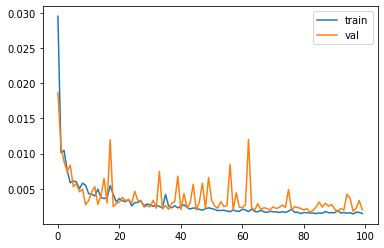

---Training time: 670.45349121 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.98200, Train (V) - 0.93481
R2 scores: Validation (SS) - 0.96772, Validation (V) - 0.93567
R2 scores: Testing (SS) - 0.92046, Testing (V) - 0.87490
RMSE scores: Train (SS) - 0.02275, Train (V) - 0.02475
RMSE scores: Validation (SS) - 0.03460, Validation (V) - 0.03070
RMSE scores: Testing (SS) - 0.05322, Testing (V) - 0.04159


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

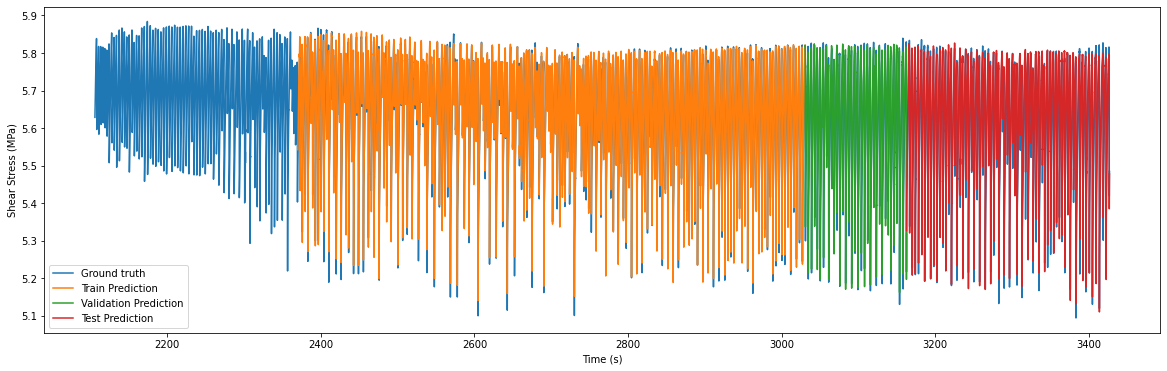

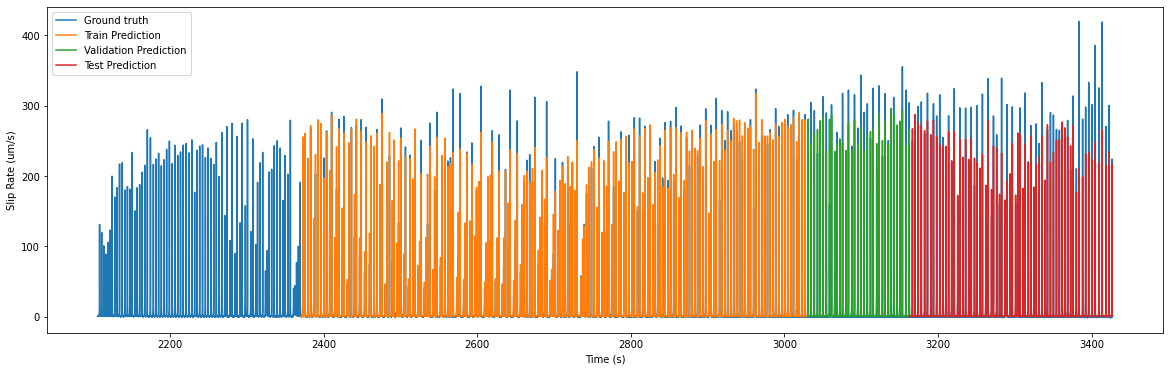

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[26420:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

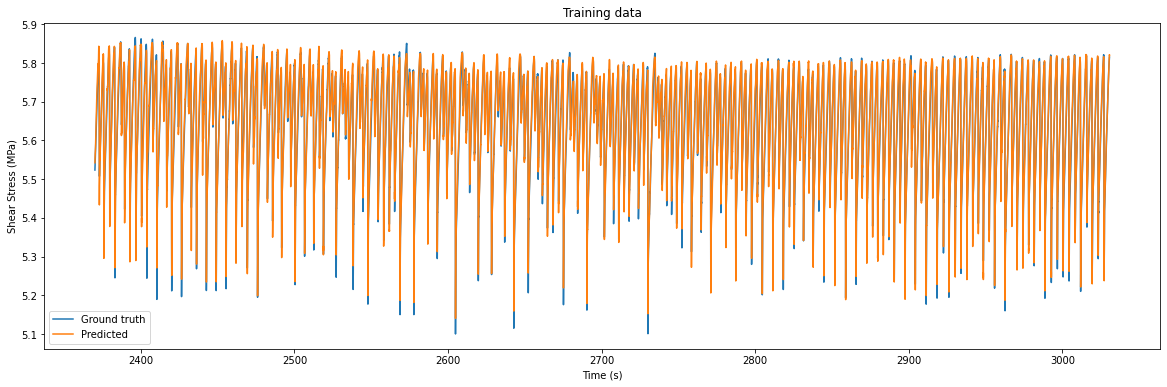

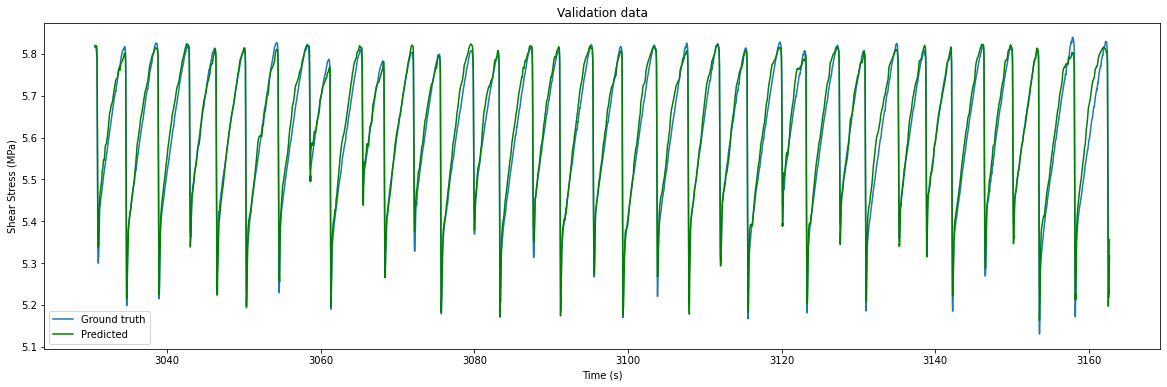

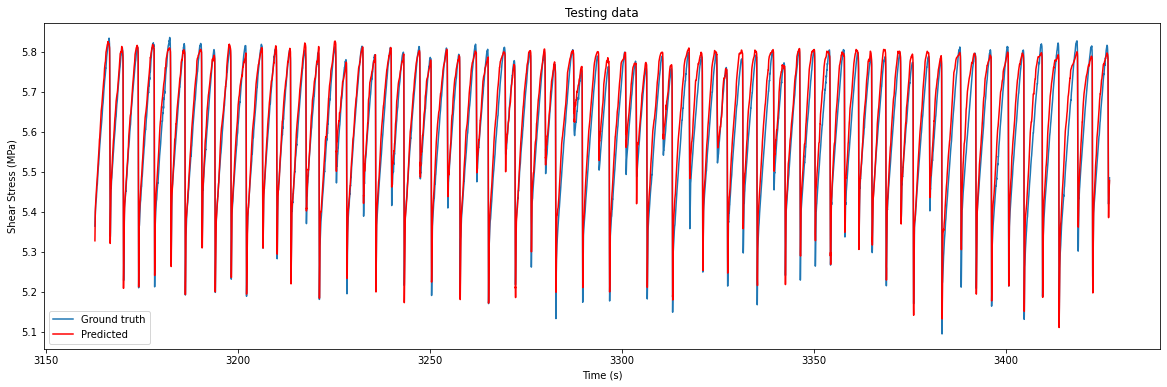

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

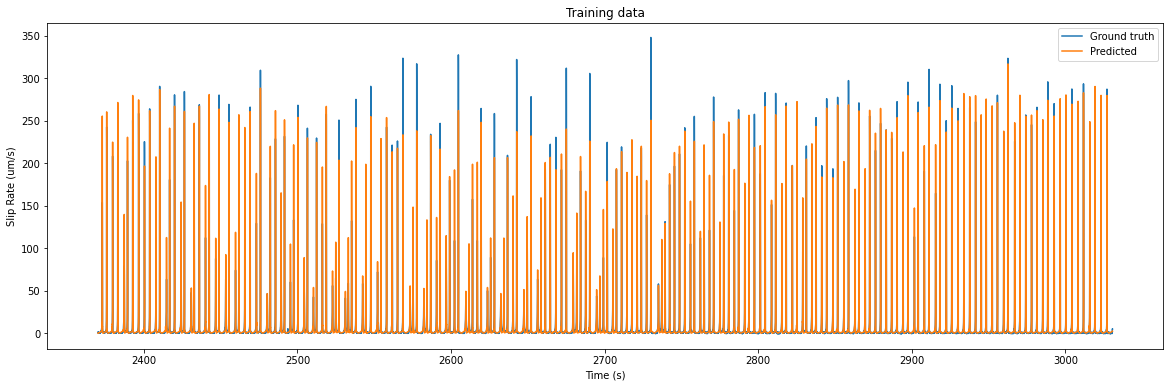

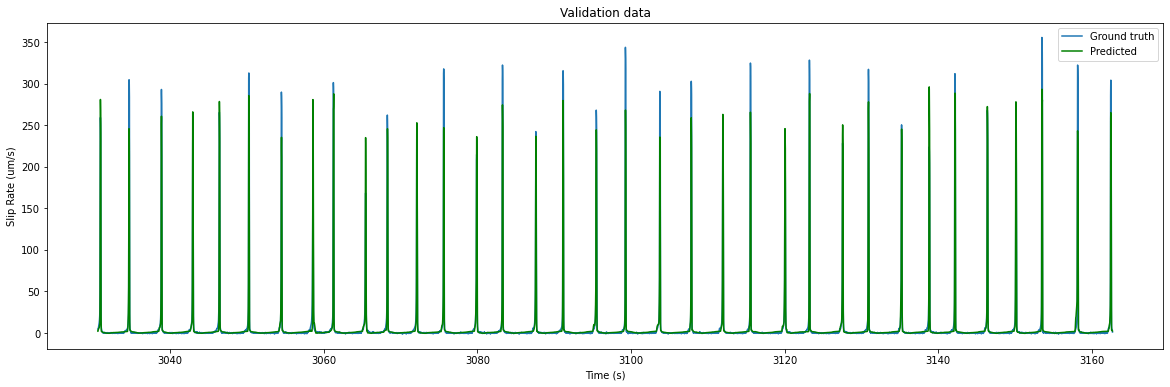

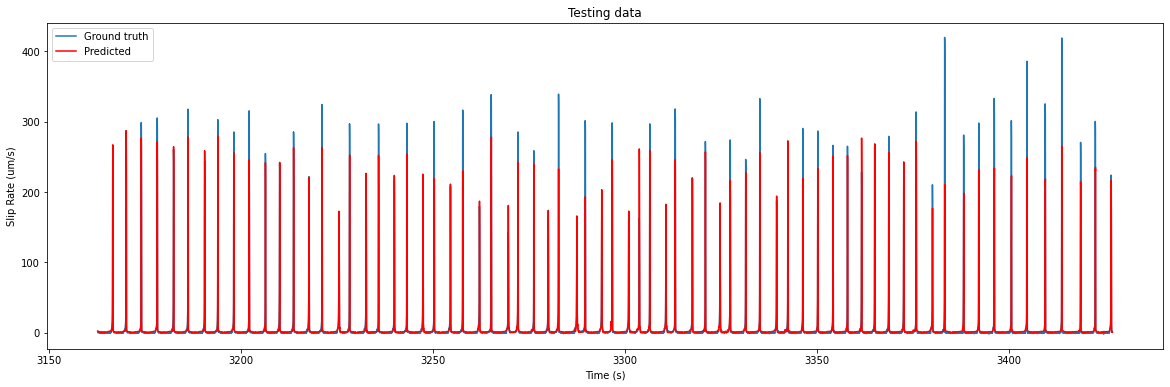

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')